#Linear Regression Implementation from Scratch (Section 3.4)
## Questions [Answers are distributed throughout code]
- A. What would happen if we were to initialize the weights to zero. Would the algorithm
still work? What if we initialized the parameters with variance 1000 rather than 0.01?
- B. Experiment using different learning rates to find out how quickly the loss function
value drops. Can you reduce the error by increasing the number of epochs of training?
- C. Try implementing a different loss function, such as the absolute value loss ‘(y hat -
d2l.reshape(y, y hat.shape)).abs().sum()‘.
  - (a) Check what happens for regular data.
  - (b) Check whether there is a difference in behavior if you actively perturb some
entries, such as y5 = 10000, of y.
  - (c) Can you think of a cheap solution for combining the best aspects of squared loss
and absolute value loss?

In [ ]:
!pip install d2l==1.0.3
%matplotlib inline
import torch
from d2l import torch as d2l

- **A. What would happen if we were to initialize the weights to zero. Would the algorithm
still work? What if we initialized the parameters with variance 1000 rather than 0.01?**

error in estimating w: tensor([ 0.1222, -0.2105])
error in estimating b: tensor([0.2323])


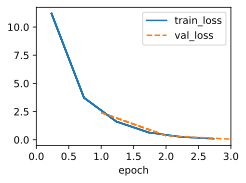

In [ ]:
class LinearRegressionScratch(d2l.Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.00): # CHANGED SIGMA = 0 TO INITIALIZE ALL WEIGHTS TO 0
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True) # [ORIG]
        #self.w = torch.zeros(1, requires_grad=True) # [Part a]
        self.b = torch.zeros(1, requires_grad=True)

@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

# Create Model - CHANGE LEARNING RATE HERE
model = LinearRegressionScratch(2, lr=.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

# Ouptut Error
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

See line 3 for the variance adjustment to sigma = 0. Initializing the weights to 0 does not seem to cause any issues at first glance, but the issue of vanishing/exploding gradients can come into play during back propogation. It is best practice to never initialize weights to 0.

error in estimating w: tensor([-25.6344,  -6.3197])
error in estimating b: tensor([-0.6945])


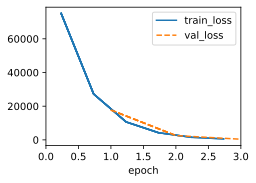

In [ ]:
class LinearRegressionScratch(d2l.Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=1000.00): # CHANGED SIGMA = 1000
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True) # [ORIG]
        #self.w = torch.zeros(1, requires_grad=True) # [Part a]
        self.b = torch.zeros(1, requires_grad=True)

@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

# Create Model - CHANGE LEARNING RATE HERE
model = LinearRegressionScratch(2, lr=.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

# Ouptut Error
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

Using variance=1000 causes an extremely large first loss value and the algorithm tends to have errors for w, b greater than 1. This large variance value can cause issues of exploding gradients as well as unstable training (the updates to the weights during each iteration can become extremely large, making the optimization process difficult to control).

- **B. Experiment using different learning rates to find out how quickly the loss function
value drops. Can you reduce the error by increasing the number of epochs of training?**

error in estimating w: tensor([ 0.9019, -1.5144])
error in estimating b: tensor([1.8596])


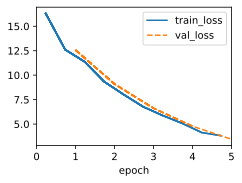

In [ ]:
# Create Model
model = LinearRegressionScratch(2, lr=.005, sigma=.01) # CHANGE LEARNING RATE HERE
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

With a smaller learning rate (.005 << .03), the initial loss value is higher and it does not reach zero without extending the number of epochs. Increasing the number of epochs does reduce the error.

error in estimating w: tensor([-0.0013,  0.0008])
error in estimating b: tensor([-0.0029])


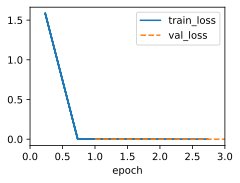

In [ ]:
# Create Model
model = LinearRegressionScratch(2, lr=.5, sigma=.01) # CHANGE LEARNING RATE HERE
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

Increasing the learning rate (0.5 >> 0.03) seems to lead to faster convergence, but this does introduce the potential for overshooting. Choosing a proper learning rate is key to the model's success.

- **C. Try implementing a different loss function, such as the absolute value loss ‘(y hat -
d2l.reshape(y, y hat.shape)).abs().sum()‘.**
  - (a) **Check what happens for regular data.**

error in estimating w: tensor([-0.3435,  0.1684])
error in estimating b: tensor([-0.4800])


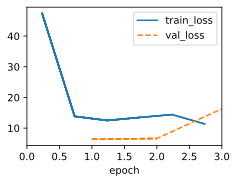

In [ ]:
# ORIGINAL LOSS FUNCTION - MEAN SQUARED
# @d2l.add_to_class(LinearRegressionScratch)
# def loss(self, y_hat, y):
#     l = (y_hat - y) ** 2 / 2
#     return l.mean()

# PART C.A NEW LOSS FUNCTION - ABSOLUTE VALUE LOSS
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()
    return l.mean()

# Create Model
model = LinearRegressionScratch(2, lr=.03, sigma=.01) # CHANGE LEARNING RATE HERE
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

The loss values do not seem to converge to zero - rather, they hover around ~10 even when increasing the epochs. Despite this, the resulting error is interestingly still on the scale of ~0.01 - 0.1.

- (b) **Check whether there is a difference in behavior if you actively perturb some entries, such as y5 = 10000, of y.**



error in estimating w: tensor([ 0.1618, -0.2177])
error in estimating b: tensor([-0.1800])


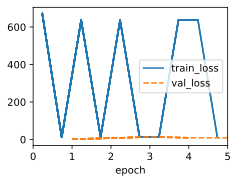

In [ ]:
# Create Model - CHANGE LEARNING RATE HERE
model = LinearRegressionScratch(2, lr=.03, sigma=.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

# PART C - PERTURBING DATA POINT
data.y[4] = 10000
##########
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

# Ouptut Error
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

  Perturbing an entry to a value of 10000 significantly magnifies the loss value to ~600 and causes it to oscillate. However, when the mean squared loss is used, the loss is magnified up to ~100000, so clearly the mean squared loss function is much more sensitive to outliers.

  - (c) **Can you think of a cheap solution for combining the best aspects of squared loss
and absolute value loss?**


error in estimating w: tensor([-0.0178, -0.0356])
error in estimating b: tensor([0.0116])


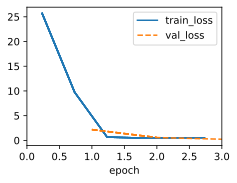

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y.reshape(y_hat.shape)) ** 2
    l = l.sum().mean().pow(0.5)
    return l
model = LinearRegressionScratch(2, lr=.03, sigma=.01) # CHANGE LEARNING RATE HERE
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')


One way is to just use the square root of the mean squared loss to reduce its sensitivity to outliers. This works fairly well as tested in the above code.

error in estimating w: tensor([ 0.0672, -0.2343])
error in estimating b: tensor([0.2420])


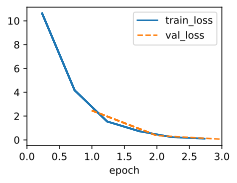

In [ ]:
# HUBER LOSS. High delta more like squared loss, low delta more like abs value (more robust to outliers)
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y, delta=40.0): # SET DELTA VALUE HERE
    residual = torch.abs(y - y_hat)
    l = torch.where(residual < delta, 0.5 * residual**2, delta * (residual - 0.5 * delta))
    return l.mean()
model = LinearRegressionScratch(2, lr=.03, sigma=.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')


Another solution is to use the Huber loss - setting a proper delta parameter can achieve error minimization close to the same speed as the square root of the mean squared error. However, the square root method seems to be more reliable (no delta parameter guessing needed).